In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
import torch
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_dir = '/scratch/ksf293/equivariant-cosmology/data'
snap_num_str = '099'
sim_name = 'TNG100-1'
sim_name_dark = 'TNG100-1-Dark'

In [3]:
sim_reader = SimulationReader(base_dir, sim_name, 
                              sim_name_dark, snap_num_str)
sim_reader.read_simulations()
sim_reader.match_twins()

In [4]:
# sim_reader.halos_dark['GroupFirstSub'] = sim_reader.halos_dark['GroupFirstSub'].astype('int32')
# mask_has_subhalos = np.where(sim_reader.halos_dark['GroupFirstSub'] >= 0) # filter out halos with no subhalos
# idxs_halos_dark_withsubhalos = sim_reader.idxs_halos_dark_all[mask_has_subhalos]
# idxs_largestsubs_dark_all = sim_reader.halos_dark['GroupFirstSub'][mask_has_subhalos]

In [5]:
#idxs_largestsubs_dark_all.shape

In [6]:
halo_logmass_min = 10
halo_mass_min = 10**halo_logmass_min
halo_mass_min /= sim_reader.mass_multiplier # because masses in catalog have units of 10^10 M_sun/h
# TO MSUN
#halo_mass_min *= 0.67
i_above_min = sim_reader.halos_dark['GroupMass'] > halo_mass_min
print(np.sum(i_above_min))

105143


In [7]:
print("Number total:", len(sim_reader.halos_dark['GroupFirstSub']))
i_withsubs_all = sim_reader.halos_dark['GroupFirstSub'] >= 0
print('Number with subhalos:', np.sum(i_withsubs_all))

print()
print("Number above mass min:", np.sum(i_above_min))
i_withsubs_all_abovemin = sim_reader.halos_dark['GroupFirstSub'][i_above_min] >= 0
print('Number above min mass with subhalos:', np.sum(i_withsubs_all_abovemin))

Number total: 4231400
Number with subhalos: 3732158

Number above mass min: 105143
Number above min mass with subhalos: 105141


In [8]:
idxs_largestsubs_dark = sim_reader.halos_dark['GroupFirstSub'][i_above_min & i_withsubs_all]
i_matched = np.isin(idxs_largestsubs_dark, list(sim_reader.subhalo_dark_to_full_dict.keys()))
print('Number with matched subhalo:', np.sum(i_matched))

Number with matched subhalo: 104895


In [29]:
idxs_subhalo_hydro = [sim_reader.subhalo_dark_to_full_dict[idx] for idx in idxs_largestsubs_dark[i_matched]]

In [30]:
num_star_particles_min = 50
i_starmin = sim_reader.subhalos_hydro['SubhaloLenType'][:,sim_reader.ipart_star][idxs_subhalo_hydro] > num_star_particles_min
print('Number with minimum num star particles:', np.sum(i_starmin))

Number with minimum num star particles: 32411


Mostly the star particle limit that cuts down the numbers so much!

In [31]:
idxs_halos_dark = sim_reader.idxs_halos_dark_all[i_above_min & i_withsubs_all][i_matched][i_starmin]
print(len(idxs_halos_dark))

32411


In [32]:
len(sim_reader.subhalos_hydro['SubhaloGrNr'])

4371211

In [33]:
idxs_halos_hydro = sim_reader.subhalos_hydro['SubhaloGrNr'][idxs_subhalo_hydro][i_starmin]
print(len(idxs_halos_hydro))

32411


In [34]:
halo_mass_difference_factor = 3
i_nottoodiff = sim_reader.halos_hydro['GroupMass'][idxs_halos_hydro] <= \
            halo_mass_difference_factor*sim_reader.halos_dark['GroupMass'][idxs_halos_dark]
print("Number with dark and hydro masses too different (bad match):", np.sum(i_nottoodiff))

Number with dark and hydro masses too different (bad match): 31838


In [35]:
#idxs_halo_dark = [halo.idx_halo_dark for halo in dark_halo_arr]
i_with_SAM_match = sim_reader.get_halos_with_SAM_match(idxs_halos_dark)

Keeping 32262/32411 halos with SAM matches


In [36]:
print('Number with SAM match:', np.sum(i_with_SAM_match))

Number with SAM match: 32262


In [37]:
i_with_halo_structure_info = sim_reader.has_halo_structure_info(idxs_halos_dark)
print('Number with structure info:', np.sum(i_with_halo_structure_info))

Keeping 32048/32411 halos with halo structure info
Number with structure info: 32048


Ahaa! Why so few here?/

In [38]:
n_part_dm = sim_reader.halos_dark['GroupLen'][i_above_min & i_withsubs_all]

In [39]:
np.min(n_part_dm), np.max(n_part_dm)

(1667, 68478588)

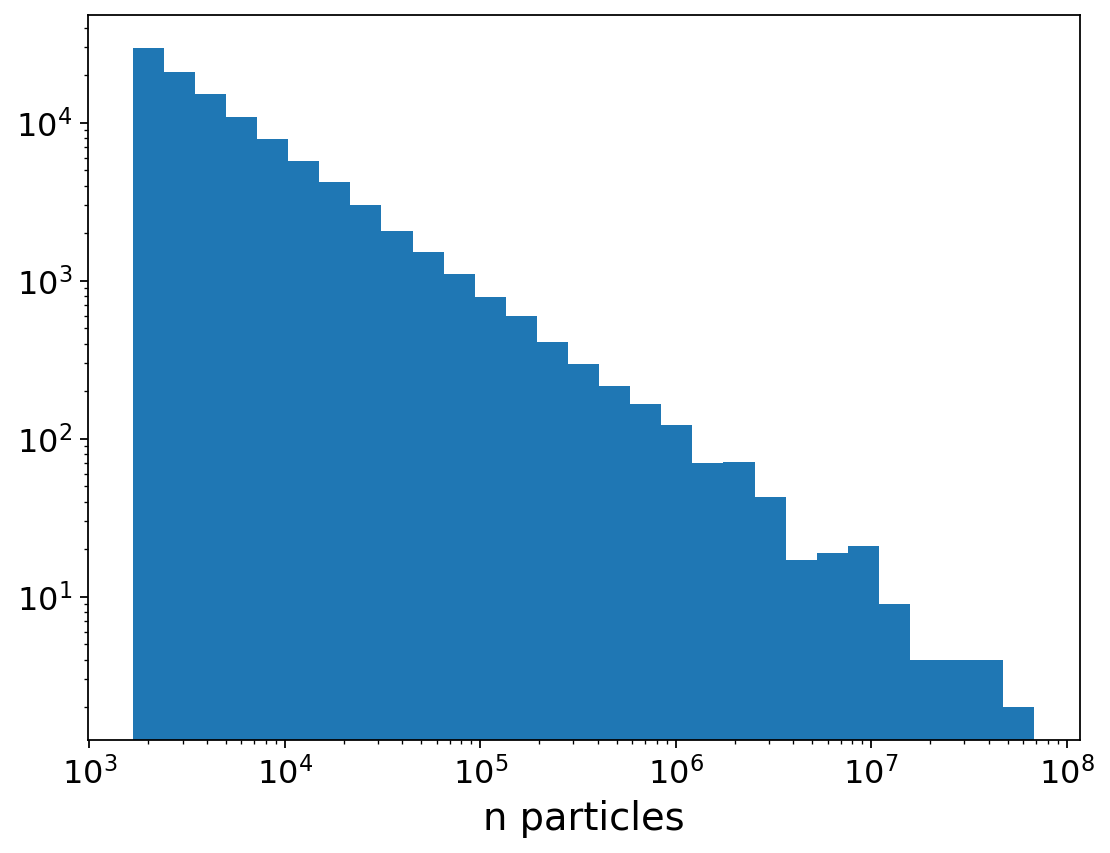

In [40]:
plt.figure(figsize=(8,6))
bins = np.logspace(np.log10(np.min(n_part_dm)), np.log10(np.max(n_part_dm)), 30)
plt.hist(n_part_dm, bins=bins)
plt.xlabel('n particles')
plt.xscale('log')
plt.yscale('log')

In [41]:
i_under2000 = n_part_dm < 2000
print(np.sum(i_under2000))
print(len(n_part_dm))

16016
105141
